# Analysis of Monthly Mean Hydrologic Future Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. 

Variables include:
- Total Runoff
- ET

In [1]:
from loca import print_date
print_date()

Last executed: 2019-03-18 04:13:54.202524 by jvano on r6i6n30


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change

# CACHED:
models = ['ACCESS1-0', 'CanESM2']
# models = ['MIROC5', 'MRI-CGCM3']
# models = ['bcc-csm1-1']
# models = ['bcc-csm1-1-m', 'CCSM4']
# models = ['CESM1-BGC', 'CESM1-CAM5']
# models = ['CMCC-CM']
# models = ['GISS-E2-R']
# models = ['HadGEM2-CC']
# models = ['HadGEM2-ES', 'inmcm4']
# models = ['IPSL-CM5A-MR']
# models = ['MIROC-ESM', 'MIROC-ESM-CHEM']
# models = ['MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M']
# models = ['GFDL-ESM2G']

# NOT YET CASHED:

# ISSUES:
# models = ['CNRM-CM5']  # problem with lon
# models = ['ACCESS1-3'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/access1-3_rcp85_r*/*nc
# models = ['CMCC-CMS'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/cmcc-cms_rcp85_r*/*nc
# models = ['CSIRO-Mk3-6-0'] # ValueError: cannot reindex or align along dimension 'lon' because the index has duplicate values
# models = ['EC-EARTH'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/ec-earth_rcp85_r
# models = ['FGOALS-g2'] # ValueError: cannot reindex or align along dimension 'lon' because the index has duplicate values
#checked above
# models = ['GFDL-ESM2M']  #ValueError: cannot reindex or align along dimension 'lon' because the index has duplicate values
# models = ['GFDL-CM3'] # cannot reindex or align along dimension 'lon' because the index has duplicate values
# models = ['GISS-E2-H'] # /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/giss-e2-h_rcp85_r*/*nc
# models = ['HadGEM2-AO'] # ValueError: zero-size array to reduction operation minimum which has no identity
# models = ['IPSL-CM5A-LR'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/ipsl-cm5a-lr_rcp85_r*/*nc

#OTHER ERRORS:
# when rang IPSL-CM5A-MR, got error - but restarted kernel and it ran ok # KilledWorker: ('open_dataset-400ff45c9031d93361ea0737b1a2666dbounds_latitude-b94c7aafe69164f36759f70bbaf6b6eb', 'tcp://10.148.0.193:37752')

# LISTS:
# models = ['ACCESS1-0', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3'] #JAV: CNRM_CM5 has an issue

# ALL:
# models = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC5', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M']

hydro_vars = ['ET', 'total_runoff']

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://10.148.10.13:47288 Dashboard: proxy/8787/status,Cluster Workers: 72 Cores: 288 Memory: 360.00 GB


# Load Data

In [4]:
write_cache = False  #TODO write if Statement to prevent reading when (When "write_cache = True" script will run )

if write_cache:
    xr.set_options(file_cache_maxsize=12000)
    hist_data = load_monthly_cmip_hydro_datasets('historical', models=models, autoclose=False, parallel=True)
    rcp4_data = load_monthly_cmip_hydro_datasets('rcp45', models=models, autoclose=False, parallel=True)
    rcp8_data = load_monthly_cmip_hydro_datasets('rcp85', models=models, autoclose=False, parallel=True)

In [5]:
if write_cache:
    for key, ds in hist_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_{gcm}.nc'))
    for key, ds in rcp4_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp4.{key}_{gcm}.nc'))
    for key, ds in rcp8_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp8.{key}_{gcm}.nc'))

In [6]:
read_cache = True
hist_data = {}
rcp4_data = {}
rcp8_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp4_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})

In [7]:
#rcp8_data.items()
# os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp4.{key}_*.nc')
# rcp8_data
# hist_data

In [8]:
hist_epoch = slice('1969-01-01', '1999-12-31')
futr_epoch = slice('2069-01-01', '2099-12-31')

mask = hist_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

hist_means = dict((k, resample_monthly_data(ds.sel(time=hist_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in hist_data.items())
rpc4_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp4_data.items())
rpc8_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp8_data.items())


# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [9]:
kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 800},}
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]

In [37]:
# JAV attempts to plot ensemble averages

# subcols = [('Historical', hist_means)]
# hydro_vars = ['total_runoff']

# for var in hydro_vars:
    
#         fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 4*len(models)))
        
#         for row, model in enumerate(models):
#             for i, dset in enumerate(['bcsd']):
#                 for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
#                     ax = axes[row, col]
                
#                     if col == 0:
#                         ax.set_ylabel(model)
#                     if row == 0:
#                         if '4.5' in title:
#                             title = dset.upper() + '\n' + title
#                         ax.set_title(title)
                
#                 ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
#         fig.suptitle(var.upper() + ' [mm/y]', fontsize=16, y=1)
#         fig.tight_layout()    

KilledWorker: ('open_dataset-49e4cffb3e9e1ad2a8dfd49d42bad6fdET-e0ef00a21c803c28f75fb2fae1a7e8d8', 'tcp://10.148.6.75:40344')

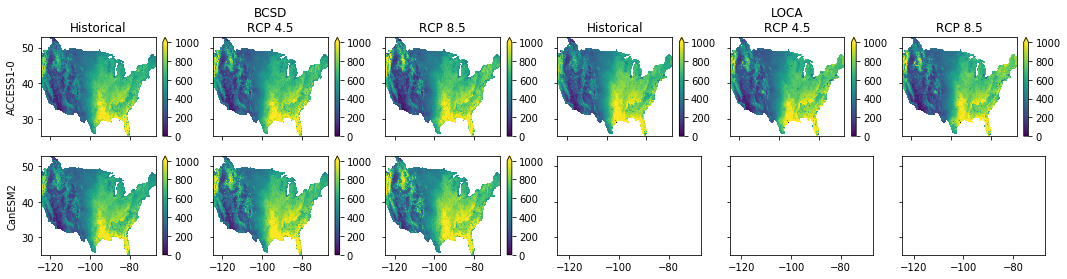

In [10]:
for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    if '4.5' in title:
                        title = dset.upper() + '\n' + title
                    ax.set_title(title)
                
                ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
    fig.suptitle(var.upper() + ' [mm/y]', fontsize=16, y=1)
    fig.tight_layout()    

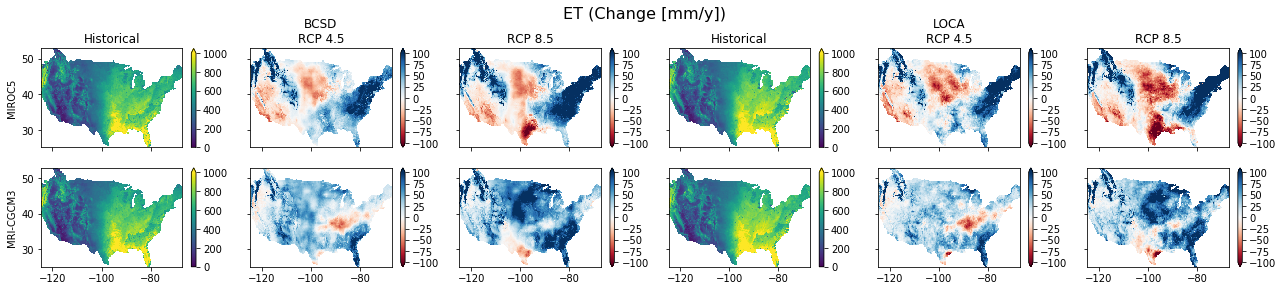

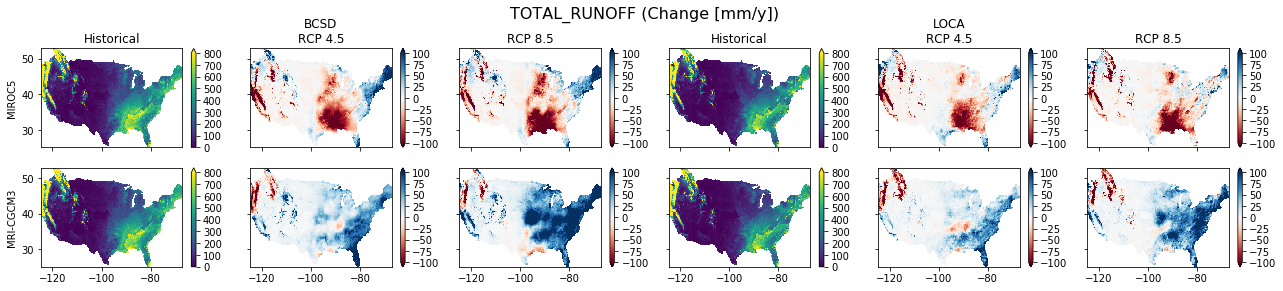

In [11]:
diff_kws = {True: {'ET': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for var in hydro_vars:

    for pct in [False]:
    
        fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
        kws = diff_kws[pct][var]

        for row, model in enumerate(models):
            for i, dset in enumerate(['bcsd', 'loca']):
                for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                    ax = axes[row, col]

                    if col == 0:
                        ax.set_ylabel(model)
                    if row == 0:
                        if '4.5' in title:
                            title = dset.upper() + '\n' + title
                        ax.set_title(title)
                    if 'RCP' in title:
                        calc_change(hist_means[dset][var].sel(gcm=model),
                                    ds_dict[dset][var].sel(gcm=model),
                                    pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **kws)
                    else:
                        ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

        if pct:
            change_str = ' (% Change)'
            unit_str = 'pct'
        else:
            change_str = ' (Change [mm/y])'
            unit_str = 'mm'
        fig.suptitle(var.upper() + change_str, fontsize=16, y=1)
        fig.tight_layout() 
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')


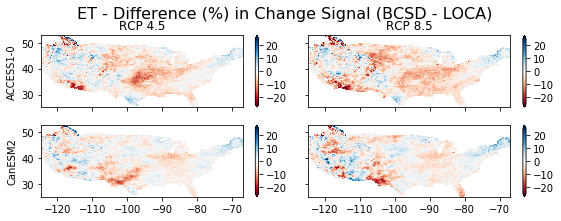

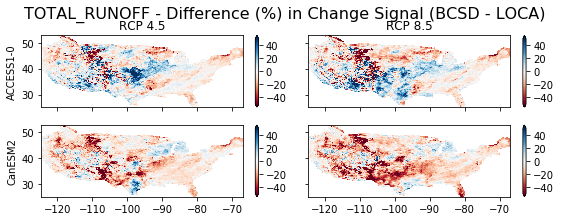

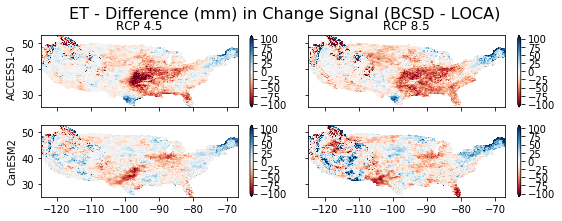

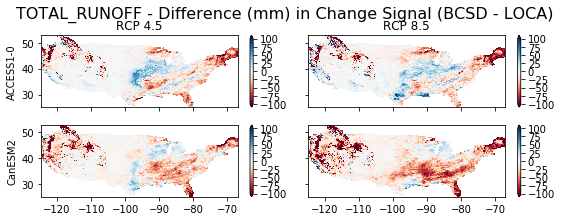

In [9]:

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [True, False]:
    for var in hydro_vars:
        
        if var not in diff_kws[pct]:
            continue

        fig, axes = plt.subplots(ncols=2, nrows=len(models), sharex=True, sharey=True, figsize=(8, 1.5*len(models)))

        for row, model in enumerate(models):
            for col, (title, ds_dict) in enumerate(subcols[1:]):

                ax = axes[row, col]

                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)                    

                bcsd_diff = calc_change(ds_dict['bcsd'][var].sel(gcm=model),  hist_means['bcsd'][var].sel(gcm=model), pct=pct)
                loca_diff = calc_change(ds_dict['loca'][var].sel(gcm=model),  hist_means['loca'][var].sel(gcm=model), pct=pct)

                (bcsd_diff - loca_diff).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        
        if pct:
            title = var.upper() + " - Difference (%) in Change Signal (BCSD - LOCA)"
            unit_str = 'pct'
        else:
            unit_str = 'mm'
            title = var.upper() + " - Difference (%s) in Change Signal (BCSD - LOCA)" % unit_str
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff2_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        

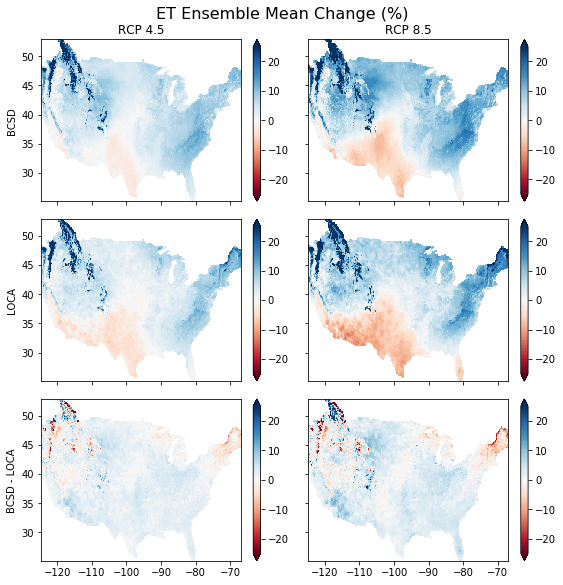

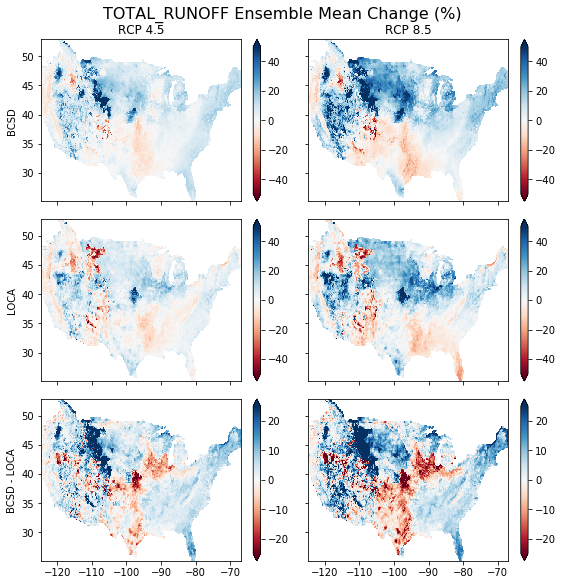

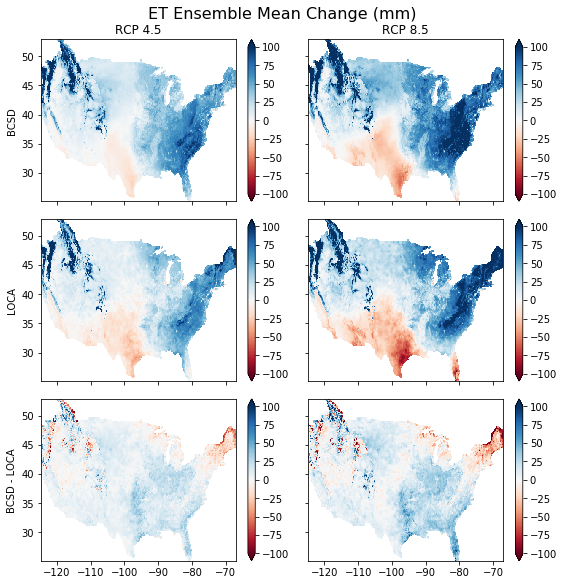

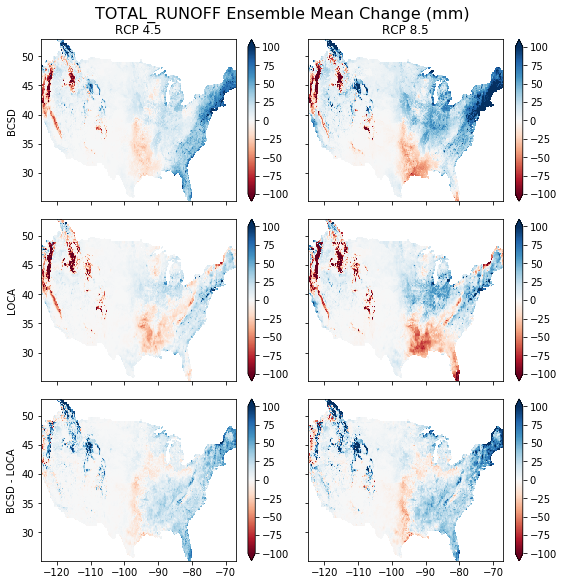

In [22]:
cache = {}

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [True, False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(8, 8))

        for col, (title, dsets) in enumerate(subcols[1:]):

            for row, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct) #diff between gcms

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(title)
                if col == 0:
                    ax.set_ylabel(dset.upper())

            diff = cache[(row - 1, col)] - cache[(row, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])
        axes[-1, 0].set_ylabel('BCSD - LOCA')

    
        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
#         fig.savefig(f'/glade/u/home/jhamman/workdir/loca_figs/diff3_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        
    

In [48]:
# plt.ens_change(hist_means[dset][var].mean('gcm'))
#subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
#cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(12, 8))

    hist_means['bcsd']['total_runoff'].mean('gcm')
    plt.show()

#.plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

AttributeError: module 'matplotlib.pyplot' has no attribute 'hist_means'

In [57]:
hist_means['bcsd']['total_runoff'].mean('gcm')

<xarray.DataArray 'total_runoff' (lat: 222, lon: 462)>
dask.array<shape=(222, 462), dtype=float32, chunksize=(222, 462)>
Coordinates:
  * lat      (lat) float32 25.1875 25.3125 25.4375 ... 52.5625 52.6875 52.8125
  * lon      (lon) float32 -124.6875 -124.5625 -124.4375 ... -67.1875 -67.0625
    time     datetime64[ns] 1950-01-16

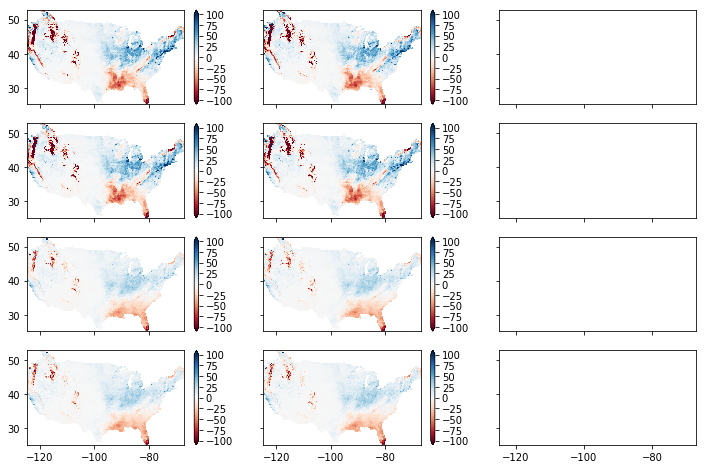

In [47]:
#JUNK
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['total_runoff']

for pct in [False]:

    for var in hydro_vars:
        fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=True, figsize=(12, 8))

        for col, dset in enumerate(['bcsd', 'loca']):

            for row, (title, dsets) in enumerate(subcols[1:]):
                ax = axes[row, col]
                #ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                #cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                #if row == 0:
                #    ax.set_title(dset.upper())
                #if col == 0:
                #    ax.set_ylabel(title)

            #diff = cache[(row, col)] - cache[(row - 1, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])
            diff.plot.pcolormesh(ax=axes[row + 2, col], add_labels=False, **diff2_kws[pct][var])





KilledWorker: ("('open_dataset-6f78aa97b3d4241bcf48d8c6c8b968c5total_runoff-3b6c04aa20c47a33599b2212be40ee26', 0, 0, 0)", 'tcp://10.148.6.75:37370')

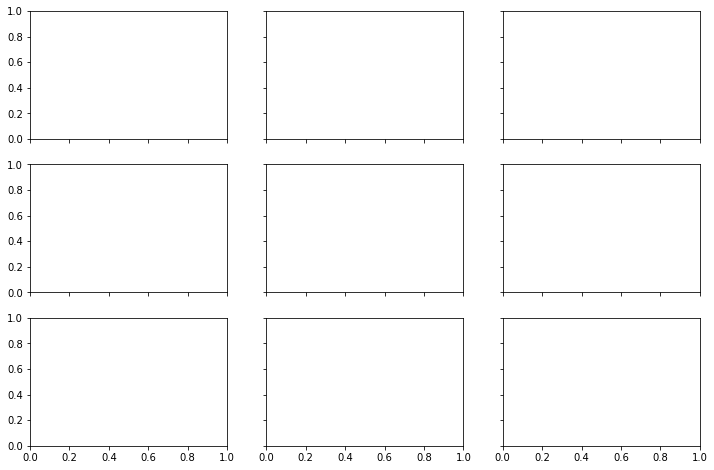

In [64]:
cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET', 'total_runoff']
# hydro_vars = ['total_runoff']

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for col, dset in enumerate(['bcsd', 'loca']):

            for row, (title, dsets) in enumerate(subcols[1:]):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col)] - cache[(row - 1, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])
            
#             diff2 = cache[(row, col)] - cache[(row, col - 1)]
#             diff2.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')

        

        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()          
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4b_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        

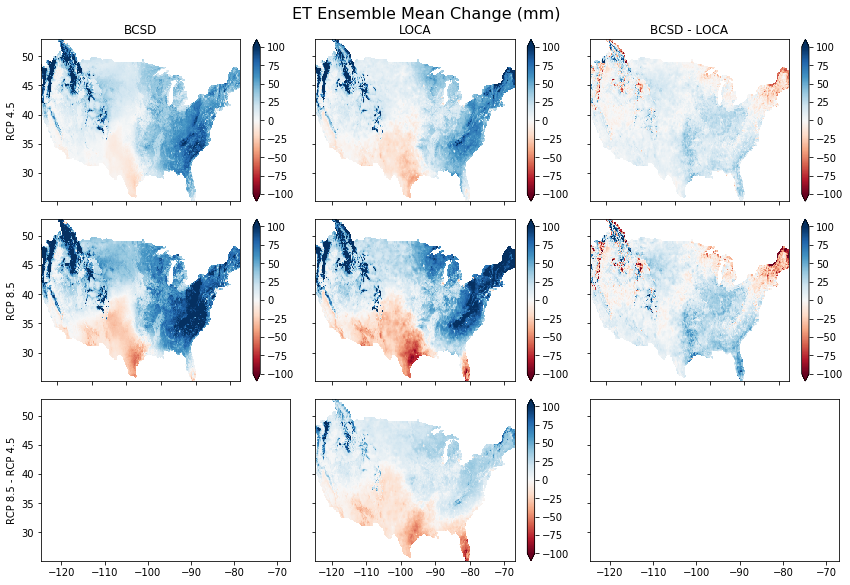

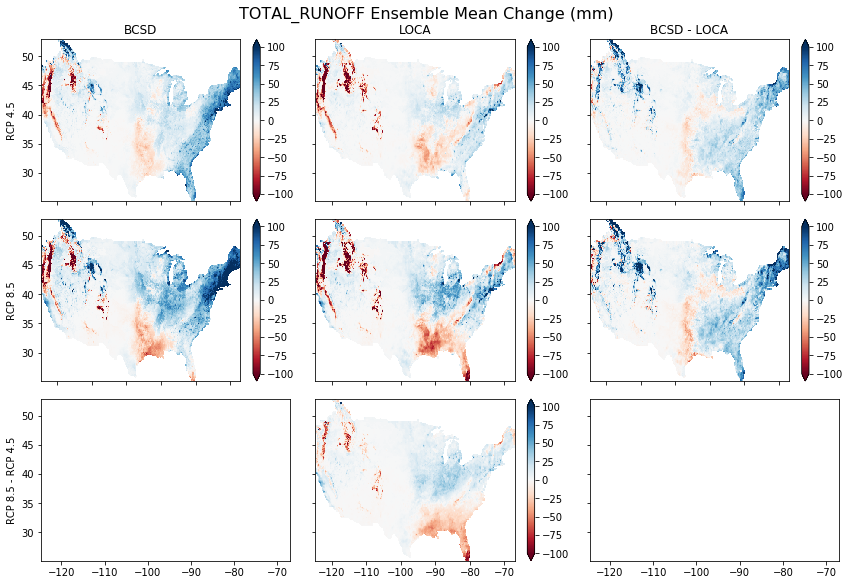

In [17]:
cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET', 'total_runoff']


diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for row, (title, dsets) in enumerate(subcols[1:]):

            for col, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col - 1)] - cache[(row, col)]
            diff.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            axes[0, -1].set_title('BCSD - LOCA')
            
        diff2 = cache[(row, col)] - cache[(row - 1, col)]
        diff2.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])  # only plots second row.  how loop it in?
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')

    
        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4a_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        
    

In [11]:
plt.close('all')